In [65]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
plt.style.use('seaborn-darkgrid')

In [5]:
import glob

#list all csv files in a directory
csv_files = glob.glob('Data/*.csv')

dataframes = []
#loop through each csv file and read it into a dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dataframes.append(df)

In [6]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13119 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         13119 non-null  object 
 1   year          13119 non-null  int64  
 2   price         13119 non-null  int64  
 3   transmission  13119 non-null  object 
 4   mileage       13119 non-null  int64  
 5   fuelType      13119 non-null  object 
 6   tax           13119 non-null  int64  
 7   mpg           13119 non-null  float64
 8   engineSize    13119 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 922.6+ KB


In [8]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000
mean,2017.296288,24698.596920,21949.559037,129.972178,55.155843,2.071530
std,2.224709,11842.675542,21176.512267,65.260286,15.220082,0.572426
min,1970.000000,650.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,17450.000000,6097.500000,125.000000,45.600000,1.800000
50%,2018.000000,22480.000000,15189.000000,145.000000,56.500000,2.000000
75%,2019.000000,28980.000000,31779.500000,145.000000,64.200000,2.100000
max,2020.000000,159999.000000,259000.000000,580.000000,217.300000,6.200000


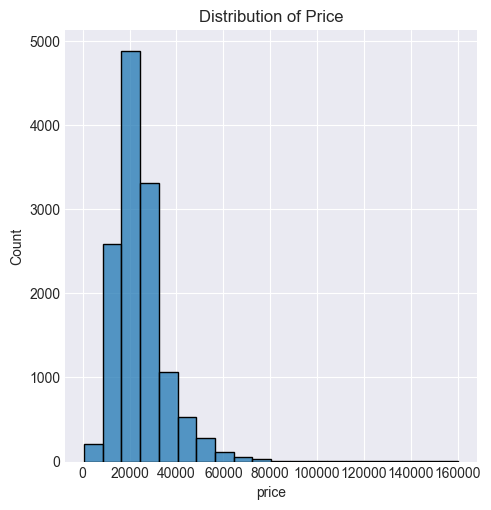

In [112]:
sns.displot(df, x = 'price', bins = 20).set(title = 'Distribution of Price')

[Text(0.5, 1.0, 'Fuel Types in Dataset')]

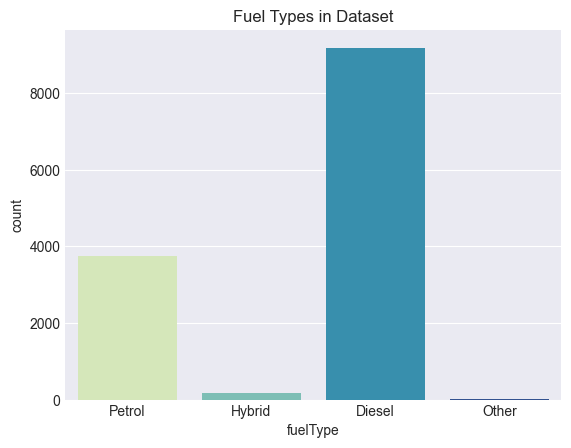

In [99]:
sns.countplot(data = df, x= 'fuelType', palette = 'YlGnBu').set(title = 'Fuel Types in Dataset')
#a large amount of the cars in this dataset run on diesel

In [25]:
otherfuelType = (df['fuelType'] == 'Other')
df.loc[otherfuelType, ['model', 'year']]
#all of the cars with fuel type == other appear to be Mercedes

,model,year
9650,GLA Class,2016
11740,GLE Class,2016
12095,C Class,2016
12184,C Class,2017
12270,C Class,2017
12389,C Class,2015
12894,C Class,2020


In [19]:
df['fuelType'].value_counts(normalize = True)
#approx 70% are diesel

Diesel    0.700282
Petrol    0.285997
Hybrid    0.013187
Other     0.000534
Name: fuelType, dtype: float64

In [21]:
fuelType_grp = df.groupby(['fuelType'])
fuelType_grp['price'].agg(['mean', 'var'])
#cars running on diesel appear to be cheaper than cars running on petrol

,mean,var
fuelType,,
Diesel,23275.122673,9.068676e+07
Hybrid,23091.572254,1.045612e+08
Other,21991.285714,1.073723e+08
Petrol,28263.208955,2.456199e+08


In [22]:
fuelType_grp['mpg'].agg(['mean', 'var'])
#clearly hybrids are more fuel efficient - diesels are not only cheaper than petrol run cars, but also more fuel efficient

,mean,var
fuelType,,
Diesel,59.020279,100.050604
Hybrid,121.189595,1831.297914
Other,126.885714,2651.601429
Petrol,42.514979,69.775713


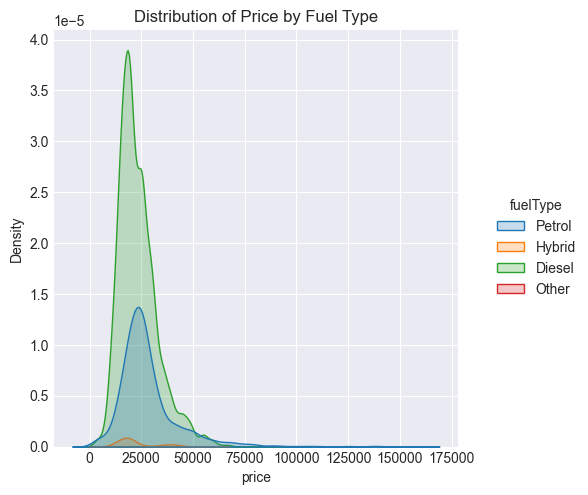

In [109]:
sns.displot(df, x = 'price', hue= 'fuelType', kind="kde", fill=True).set(title = 'Distribution of Price by Fuel Type')

In [27]:
#look closer at transmission
df['transmission'].value_counts()

Semi-Auto    6848
Automatic    4825
Manual       1444
Other           2
Name: transmission, dtype: int64

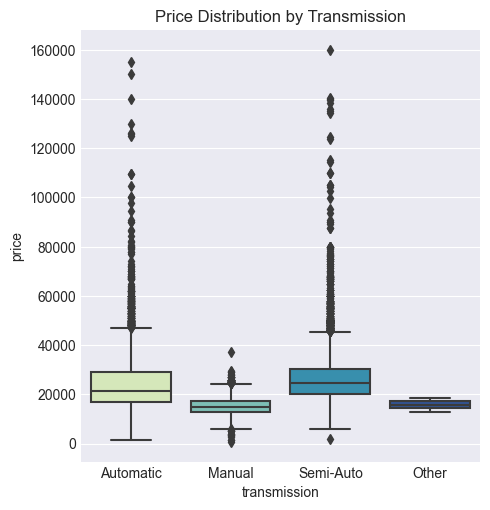

In [115]:
sns.catplot(df, x = 'transmission', y = 'price', kind = 'box', palette = 'YlGnBu').set(title = 'Price Distribution by Transmission')
#manual cars seem to have a lower average price and lower variance - possibly because less people know how to drive manual?

In [32]:
transmission_grp = df.groupby(['transmission'])
transmission_grp['price'].agg(['mean', 'var'])

,mean,var
transmission,,
Automatic,24406.959585,1.574927e+08
Manual,15442.434903,1.800214e+07
Other,15847.500000,1.627351e+07
Semi-Auto,26858.461157,1.311257e+08


In [37]:
df.var()

year          4.949331e+00
price         1.402490e+08
mileage       4.484447e+08
tax           4.258905e+03
mpg           2.316509e+02
engineSize    3.276716e-01
dtype: float64

In [45]:
#principal component analysis
features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

X = df[features]

X_norm = (X - X.mean(axis =0))/X.std(axis = 0)

pca = PCA()

X_pca = pca.fit_transform(X_norm)

names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pcadf = pd.DataFrame(X_pca, columns=names)

X_pcadf.head()

,PC1,PC2,PC3,PC4,PC5
0,1.309664,5.266804,3.407925,0.668209,2.059800
1,1.171302,-0.554761,-0.829855,-0.834708,0.141303
2,-5.659083,5.990260,-1.590576,3.453322,0.038271
3,-3.003332,3.518767,-0.931291,1.021956,0.176845
4,-3.305769,3.267053,-0.990598,1.063430,0.578633


In [46]:
pca.singular_values_

array([159.07503923, 148.52057829,  92.96663358,  79.63701298,
        56.93786897])

<function matplotlib.pyplot.show(close=None, block=None)>

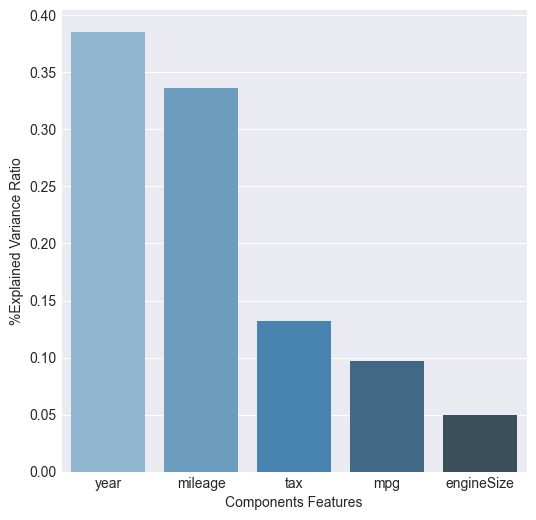

In [93]:
evr = pca.explained_variance_ratio_
features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
    
# plot the EVR using matplotlib pyplot    
plt.figure(figsize=(6,6))
sns.barplot(x = np.array(features), y = evr, palette = 'Blues_d')
plt.xlabel('Components Features')
plt.ylabel('%Explained Variance Ratio')
plt.show

In [49]:
y = df['price']

In [68]:
# split data into training and validation data, for both features and target
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
# decision tree model
rf = RandomForestRegressor()
used_car_price_model = rf
# fit model
used_car_price_model.fit(train_X, train_y)
# get predicted prices on validation data
val_predictions = used_car_price_model.predict(val_X)
#get mean absolute error for model
print(mean_absolute_error(val_y, val_predictions))

2075.7938932381257


In [70]:
#predict values in validation data
pred_y = rf.predict(val_X)

In [79]:
#dataframe comparing actual values vs predicted values
model_df = pd.DataFrame({'mileage': val_X['mileage'], 'actual_price':val_y, 'predicted_price':pred_y})
model_df

,mileage,actual_price,predicted_price
10823,8478,18800,20066.130000
10986,60514,11999,11213.420000
634,2568,33950,38234.713333
8001,2000,39999,36720.361429
722,20949,18998,19564.740000
...,...,...,...
4336,39290,14995,15831.260000
9734,37419,15975,17237.120000
7982,4606,39000,39068.246429
11850,86000,29990,24128.190000


[Text(0.5, 0, 'Mileage'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Random Forest Regressor Actual vs Predicted Price')]

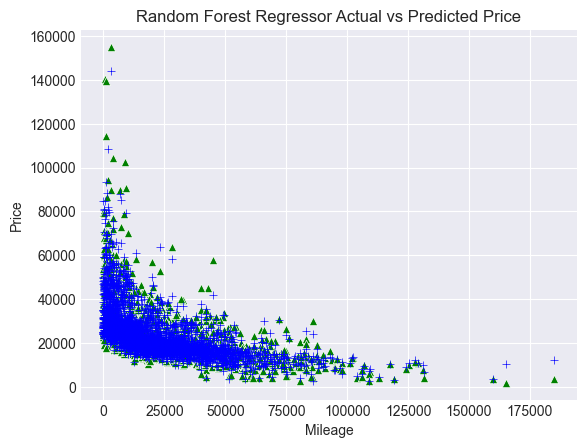

In [90]:
#actual price in green, predicted price in blue
sns.scatterplot(data = model_df, x = 'mileage', y = 'actual_price', color='g', marker = '^')
sns.scatterplot(data = model_df, x = 'mileage', y = 'predicted_price', color='b', marker = '+').set(xlabel='Mileage',
       ylabel='Price',
       title='Random Forest Regressor Actual vs Predicted Price')